In [119]:
import numpy as np
from skimage import io
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import glob
import os
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray, rgb2hsv
from sklearn.metrics import accuracy_score, f1_score
# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median, threshold_otsu
from skimage.feature import canny

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Edges
from skimage.filters import sobel_h, sobel, sobel_v, roberts, prewitt


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
import pickle

# DataSetPATH = "../input/fonts-dataset-cmp/fonts-dataset" # for kaggle
DataSetPATH = "./Dataset" # for local
from sklearn.model_selection import GridSearchCV
from sklearn import svm
sift = cv.SIFT_create(
    nfeatures=200,  # Allow more keypoints
    contrastThreshold=0.005,  # Adjusted for better sensitivity
    nOctaveLayers=5,  # Adjusted for multi-scale detection
    edgeThreshold=10,  # More edge sensitivity
   
)


In [63]:
# Show the figures / plots inside the notebook
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ["(%d)" % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


def show_3d_image(img, title):
    fig = plt.figure()
    fig.set_size_inches((12, 8))
    ax = fig.gca(projection="3d")

    # Make data.
    X = np.arange(0, img.shape[0], 1)
    Y = np.arange(0, img.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    Z = img[X, Y]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(0, 8)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title(title)
    plt.show()


def show_3d_image_filtering_in_freq(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)

    img_in_freq = fftpack.fftshift(np.log(np.abs(img_in_freq) + 1))
    filtered_img_in_freq = fftpack.fftshift(np.log(np.abs(filtered_img_in_freq) + 1))

    show_3d_image(img_in_freq, "Original Image")
    show_3d_image(filtered_img_in_freq, "Filtered Image")


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align="center")


In [64]:
def ThresholdImage(image,Trace=False):
    img=image.copy()
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # use THRESH_OTSU to detect the threshold value automatically
    img = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    num_ones = np.count_nonzero(img)
    num_zeros = img.size - num_ones

    # it means that background is white and text is black
    if num_ones > num_zeros:
        img = cv.bitwise_not(img)
    if Trace:
        print(num_ones, num_zeros)
        show_images([img], ["Thresholded Image White background and Black text"])
    return img

In [65]:
def RemoveSaltPepperNoise(image,Trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = cv.medianBlur(img, 3)
    if Trace:
        show_images([img], ["Image after removing Salt and Pepper Noise"])
    return img

In [66]:
def DeskewImage(image,real,Trace=False):

    original = image.copy()
    img = image.copy()

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    opening = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    if Trace:
        show_images([opening], ["Opening Image"])
    # Dilate the text to make the text lines more obvious.
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (35, 35))
    dilate = cv.dilate(opening, kernel)
    if Trace:
        show_images([dilate], ["Dilated Image"])

    # Find all the contours based on the dilated image.
    contours, hierarchy = cv.findContours(
        dilate, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE
    )

    # show the contours
    if Trace:
        img = cv.drawContours(real, contours, -1, (0, 255, 0), 5)
        show_images([img], ["Contours"])

    # sort the contours based on the area
    contours = sorted(contours, key=cv.contourArea, reverse=False)
    # filter out the small contours
    contours = [cnt for cnt in contours if cv.contourArea(cnt)<0.9*img.shape[0]*img.shape[1]]  

    rect = cv.minAreaRect(contours[-1])
    angle = rect[-1]
    box = cv.boxPoints(rect)
    box = np.intp(box)

    if Trace:
        cv.drawContours(img,[box],0,(0,0,255),2)
        show_images([img], ["Rotated Rectangle"])

    # Calculate distances between consecutive points
    dis = []
    for i in range(len(box)):
        # Calculate the Euclidean distance between consecutive points
        dist = np.linalg.norm(box[i] - box[(i + 1) % len(box)])
        dis.append(dist)

    if Trace:
        print(f'Angle: {angle}')
        for (x,y) in box:
            print(f'({x},{y})')
        # for i, dist in enumerate(dis):
        #     print("Distance of side {}: {:.2f}".format(i + 1, dist))
    sortedx_box = sorted(box, key=lambda k: k[0])
    sortedy_box = sorted(box, key=lambda k: k[1])
    dis0 = np.linalg.norm(sortedy_box[-1] - sortedy_box[-2])
    dis1 = np.linalg.norm(sortedx_box[-1] - sortedx_box[-2])
    if Trace:
        print(f'sorted box')
        for (x,y) in box:
            print(f'sorted ({x},{y})')
        print(f"dis0: {dis0}")
        print(f"dis1: {dis1}")

    tolernace = 35

    if angle >= 80:
        if dis0 > dis1 +  tolernace:
            angle = 0
            return original
        elif  dis1 > dis0 +  tolernace:
            angle = 90
        else:    
            angle = 0
            return original
    elif angle >=35 and angle < 55:
        angle = 45
    elif angle <= 10:
        if dis0 > dis1 + tolernace:
            angle = 0
            return original
        elif dis1 > dis0 + tolernace:
            angle = 90
        else:
            angle = 0
            return original

    height = original.shape[0]
    width = original.shape[1]
    m = cv.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    deskewed = cv.warpAffine(original, m, (width, height), borderValue=(0,0,0))

    return deskewed

In [67]:
def Preprocessing(image,Trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = RemoveSaltPepperNoise(img, Trace)
    # Threshold the image
    img = ThresholdImage(img, Trace)
    if np.count_nonzero(img) == 0:
        return None
    # Deskew the image
    deskewed = DeskewImage(img,image, Trace)
    return deskewed

In [68]:
Scheherazade=[]
destination = "./Corrected/Scheherazade New"
if not os.path.exists(destination):
    os.makedirs(destination)

for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Scheherazade New/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        Scheherazade.append(corrected)
        
        # Scheherazade.append(extract_features(img))
        # io.imsave(f"{destination}/{filename}", corrected, check_contrast=False)

100%|██████████| 1000/1000 [01:00<00:00, 16.45it/s]


In [69]:
destination = "./Corrected/IBM Plex Sans Arabic"
if not os.path.exists(destination):
    os.makedirs(destination)

IBM = []
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/IBM Plex Sans Arabic/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        IBM.append(corrected)
        # IBM.append(extract_features(img))
        # io.imsave(
        #     f"./Corrected/IBM Plex Sans Arabic/{filename}",
        #     corrected,
        #     check_contrast=False,
        # )

100%|██████████| 1000/1000 [01:13<00:00, 13.67it/s]


In [70]:
destination = "./Corrected/Marhey"
if not os.path.exists(destination):
    os.makedirs(destination)

Marhey=[]
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Marhey/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        Marhey.append(corrected)
        # Marhey.append(extract_features(img))
        # io.imsave(
        #     f"./Corrected/Marhey/{filename}",
        #     corrected,
        #     check_contrast=False,
        # )


100%|██████████| 1000/1000 [01:07<00:00, 14.77it/s]


In [71]:
destination = "./Corrected/Lemonada"
if not os.path.exists(destination):
    os.makedirs(destination)

Lemonada=[]
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Lemonada/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        Lemonada.append(corrected)
        
        # Lemonada.append(extract_features(img))
        # io.imsave(
        #     f"./Corrected/Lemonada/{filename}",
        #     corrected,
        #     check_contrast=False, )

100%|██████████| 1000/1000 [01:10<00:00, 14.18it/s]


In [72]:
Lemonada = np.array(Lemonada)
IBM = np.array(IBM)
Marhey = np.array(Marhey)
Scheherazade = np.array(Scheherazade)

Data=np.concatenate((Scheherazade,Marhey,Lemonada,IBM))
labels = np.concatenate(
    (np.zeros(Scheherazade.shape[0]), np.ones(Marhey.shape[0]), np.ones(Lemonada.shape[0]) * 2, np.ones(IBM.shape[0]) * 3)
)


X_train, X_test, Y_train, Y_test = train_test_split( Data, labels, test_size=0.4, random_state=42)
X_validation, X_test, Y_validation, Y_test = train_test_split( X_test, Y_test, test_size=0.5, random_state=42)


In [73]:
def extract_features(X_train):
     dico=[]
     data=[]
     for i, img in enumerate(X_train):
         kp, des = sift.detectAndCompute(img, None)
         data.append(des)
         if des is not None:
               for d in des:
                    dico.append(d)
     return  dico ,data
    


    

In [74]:
def train(X_train,kmeans): 
    data = []
    kmeans.verbose = False

    for img in tqdm(X_train):     
        
                histo = np.zeros(k)
                nkp = np.size(len(img))
                if(img is not None):
                    for d in img:
            
                        idx = kmeans.predict([d])
                        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly
                data.append(histo)
   
    return  data
     

  0%|          | 0/4 [00:00<?, ?it/s]c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
 25%|██▌       | 1/4 [05:56<17:48, 356.22s/it]c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
 50%|█████     | 2/4 [13:03<13:15, 397.88s/it]c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
 75%|███████▌  | 3/4 [20:23<06:57, 417.32s/it]c:\Python311\Lib\site-packages\sklearn\clu

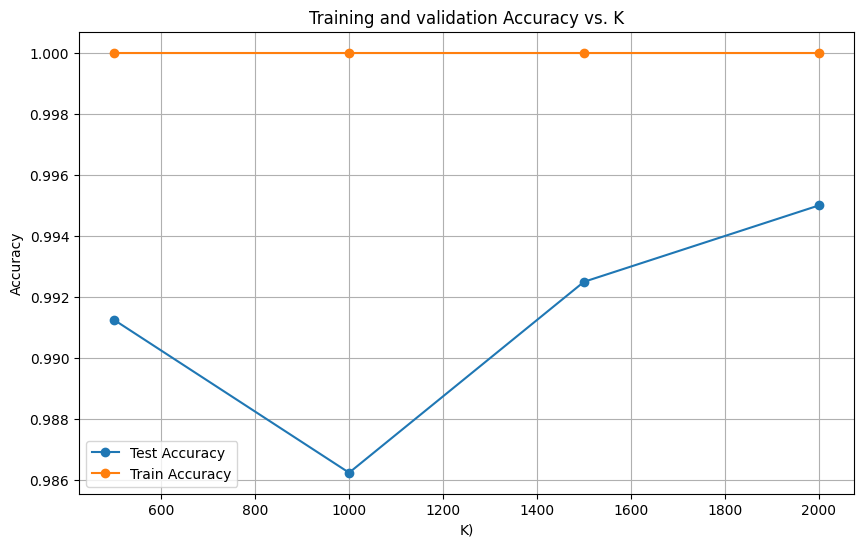

In [83]:
   
                       
dico,data_validation=extract_features(X_validation)
dico_train,data_train=extract_features(X_train)
K = [10,500,1000,1500,2000]

# Lists to store training and test accuracies
validation_accuracies = []
train_accuracies = []

# Train SVM models with different values of K
for k in tqdm(K):
    kmeans = MiniBatchKMeans(n_clusters=k, verbose=0).fit(dico_train)
    validation_histo=train(data_validation,kmeans)
    train_histo=train(data_train,kmeans)
    model = svm.SVC( C=4)
    model.fit(train_histo, Y_train)

   
    # Compute test accuracy
    validation_accuracy = model.score(validation_histo, Y_validation)
    validation_accuracies.append(validation_accuracy)

    train_accuracy = model.score(train_histo, Y_train)
    train_accuracies.append(train_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(K, validation_accuracies, marker="o", label="Test Accuracy")
plt.plot(K, train_accuracies, marker="o", label="Train Accuracy")
plt.xlabel("K)")
plt.ylabel("Accuracy")
plt.title("Training and validation Accuracy vs. K")
plt.legend()
plt.grid(True)
plt.show()

In [84]:

k=1700
kmeans = MiniBatchKMeans(n_clusters=k, verbose=0).fit(dico_train)
with open( 'kmeans.pkl', 'wb') as file:
    pickle.dump(kmeans, file)
train_histo=train(data_train,kmeans)
validation_histo=train(data_validation,kmeans)

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


100%|██████████| 799/799 [02:22<00:00,  5.62it/s]


In [122]:
#  make a prediction with probability true to debug


svm_classifier = svm.SVC(C=4.0, gamma='scale')

svm_classifier.fit(train_histo, Y_train)
with open( 'sift_svm_classifier.pkl', 'wb') as file:
    pickle.dump(svm_classifier, file)

100%|██████████| 800/800 [04:14<00:00,  3.15it/s]


Model Accuracy 99.5
F1 Score: 99.49970100450703


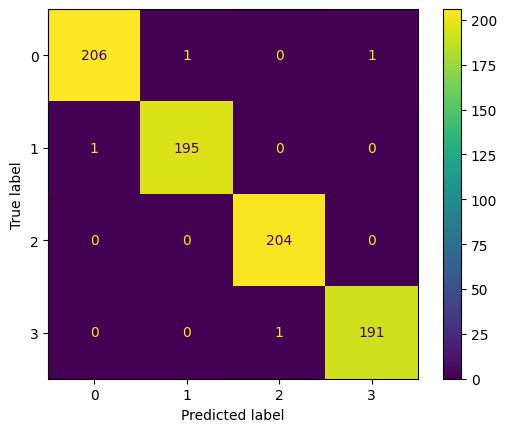

In [123]:
_,data_test=extract_features(X_test)
histo_test=train(data_test,kmeans)
svm_classifier = pickle.load(open("sift_svm_classifier.pkl", "rb"))

y_pred = svm_classifier.predict(histo_test)

print("Model Accuracy",accuracy_score(Y_test, y_pred) * 100)

# Compute F1 score (meaning that it is not biased)
f1 = f1_score(Y_test, y_pred, average="weighted")
print("F1 Score:", f1 * 100)


confusion_matrix = metrics.confusion_matrix(Y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=[0,1,2,3]
)
cm_display.plot()
plt.show()

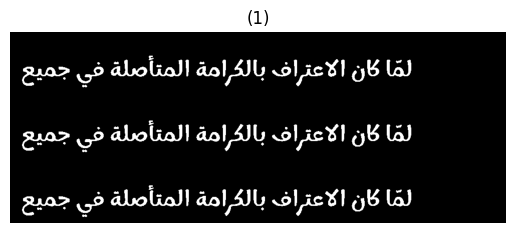

[3.]


In [132]:

filepath = glob.glob(f"M.png")[0]  # Ensure only one filepath
filename = os.path.basename(filepath)

img = io.imread(filepath)  # Load the image

corrected = Preprocessing(img)
show_images([corrected])

kp, des = sift.detectAndCompute(corrected, None)


histo = np.zeros(k)
nkp = np.size(len(des))
for d in des:
    idx = kmeans.predict([d])
    histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly
histo=histo.reshape(1,-1)
y_pred = svm_classifier.predict(histo)
print(y_pred)

